In [1]:
import torch 
import numpy as np 
import pandas as pd
import sys
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
from wrapper.utils import plot_correlation
from model import TestMotifModel
from wrapper import utils
from torch.utils.data import DataLoader
from wrapper.data_setup import SequenceDatasetDual
import matplotlib.pyplot as plt

In [2]:
fold = 1
batch_size = 256
data_folder = "/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs"

seq_fasta_train_path = f"{data_folder}/motif_fasta_train_SPLIT_{fold}.fasta"
meta_data_train_json_path = f"{data_folder}/train_meta_data_SPLIT_{fold}.json"
train_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_train_path, meta_data_path=meta_data_train_json_path)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

seq_fasta_test_path = f"{data_folder}/motif_fasta_test_SPLIT_{fold}.fasta"
meta_data_test_json_path = f"{data_folder}/test_meta_data_SPLIT_{fold}.json"
test_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_test_path, meta_data_path=meta_data_test_json_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6_info-no_promoter-False_MOTIF.pkl",
                        map_location=torch.device('cpu'))
config = {'cnn_first_filter': 16, 'cnn_first_kernel_size': 9, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 128, 'fc_size': 64}            
model = TestMotifModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                        cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                        output_size=2)
model.load_state_dict(model_weight)
model.eval()

device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TestMotifModel(
  (CNN): Sequential(
    (CNN_1): Conv1d(4, 16, kernel_size=(9,), stride=(1,), padding=same)
    (RELU_1): ReLU()
    (DROPOUT_1): Dropout(p=0.2, inplace=False)
    (BATCHNORM_1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (CNN_2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=same)
    (RELU_2): ReLU()
    (BATCHNORM_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (CNN_3): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=same)
    (RELU_3): ReLU()
    (BATCHNORM_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (biLSTM): LSTM(32, 128, num_layers=3, batch_first=Tru

In [2]:
def infer(model, data_loader, ):
    device = (torch.device("cuda") if torch.cuda.is_available()
                else torch.device("cpu"))
    model.to(device)
    model.eval()

    pred= torch.Tensor().to("cpu", non_blocking=True)
    true = torch.Tensor().to("cpu", non_blocking=True)

    for data in data_loader:
        seq = data["seq"].to(device, non_blocking=True)
        meth_true_val = torch.stack([data[f"meth_control"].to(device, non_blocking=True), 
                                        data[f"meth_case"].to(device, non_blocking=True)], dim=1)
        meth_pred_val = model(seq)
        pred = torch.cat([pred, meth_pred_val.cpu().detach()])
        true = torch.cat([true, meth_true_val.cpu().detach()])

    true_control = true[:,0]
    true_case = true[:,1]
    pred_control = pred[:,0]
    pred_case = pred[:,1]

    model.cpu()
    df = pd.DataFrame({"true_control": true_control, "true_case": true_case, "pred_control": pred_control, "pred_case": pred_case})
    del pred, true, meth_true_val, meth_pred_val, seq, true_control, true_case, pred_control, pred_case

    return df

In [3]:
device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

train_pred= torch.Tensor().to("cpu", non_blocking=True)
train_true = torch.Tensor().to("cpu", non_blocking=True)

for train_data in train_loader:
    seq = train_data["seq"].to(device, non_blocking=True)
    meth_true_val = torch.stack([train_data[f"meth_control"].to(device, non_blocking=True), 
                                    train_data[f"meth_case"].to(device, non_blocking=True)], dim=1)
    meth_pred_val = model(seq)
    train_pred = torch.cat([train_pred, meth_pred_val.cpu().detach()])
    train_true = torch.cat([train_true, meth_true_val.cpu().detach()])

true_control = train_true[:,0]
true_case = train_true[:,1]
pred_control = train_pred[:,0]
pred_case = train_pred[:,1]

model.cpu()
train_validation_df = pd.DataFrame({"true_control": true_control, "true_case": true_case, "pred_control": pred_control, "pred_case": pred_case})

del train_pred, train_true, meth_true_val, meth_pred_val, seq, true_control, true_case, pred_control, pred_case

In [4]:
device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

test_pred= torch.Tensor().to("cpu", non_blocking=True)
test_true = torch.Tensor().to("cpu", non_blocking=True)

for test_data in test_loader:
    seq = test_data["seq"].to(device, non_blocking=True)
    meth_true_val = torch.stack([test_data[f"meth_control"].to(device, non_blocking=True), 
                                    test_data[f"meth_case"].to(device, non_blocking=True)], dim=1)
    meth_pred_val = model(seq)
    test_pred = torch.cat([test_pred, meth_pred_val.cpu().detach()])
    test_true = torch.cat([test_true, meth_true_val.cpu().detach()])

true_control = test_true[:,0]
true_case = test_true[:,1]
pred_control = test_pred[:,0]
pred_case = test_pred[:,1]

model.cpu()
test_validation_df = pd.DataFrame({"true_control": true_control, "true_case": true_case, "pred_control": pred_control, "pred_case": pred_case})
del test_pred, test_true, meth_true_val, meth_pred_val, seq, true_control, true_case, pred_control, pred_case

In [281]:
np.arange(0,1.01,0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [282]:
train_validation_df["true_control_bin"] = pd.cut(train_validation_df["true_control"], bins=101, labels=np.arange(0,1.01,0.01))
train_validation_df["true_case_bin"] = pd.cut(train_validation_df["true_case"], bins=101, labels=np.arange(0,1.01,0.01))
test_validation_df["true_control_bin"] = pd.cut(test_validation_df["true_control"], bins=101, labels=np.arange(0,1.01,0.01))
test_validation_df["true_case_bin"] = pd.cut(test_validation_df["true_case"], bins=101, labels=np.arange(0,1.01,0.01))
print(train_validation_df)
print(test_validation_df)

        true_control  true_case  pred_control  pred_case true_control_bin  \
0             0.3976     0.0000      0.610820   0.557982             0.40   
1             0.3564     0.6158      0.568423   0.580558             0.35   
2             0.1444     0.1853      0.305591   0.175913             0.14   
3             0.2182     0.2208      0.293539   0.165499             0.22   
4             0.0000     0.1080      0.258205   0.225950             0.00   
...              ...        ...           ...        ...              ...   
103850        0.1837     0.0000      0.243598   0.106746             0.18   
103851        0.9804     0.9896      0.750631   0.631827             0.99   
103852        0.3638     0.0000      0.297644   0.244975             0.36   
103853        0.2810     0.0000      0.274804   0.226825             0.28   
103854        0.0000     0.3137      0.355755   0.301590             0.00   

       true_case_bin  train_control_se  train_case_se  
0               0.0

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

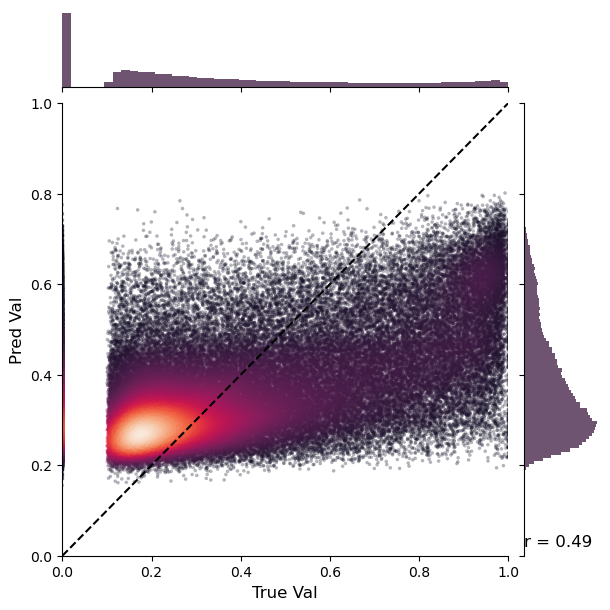

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

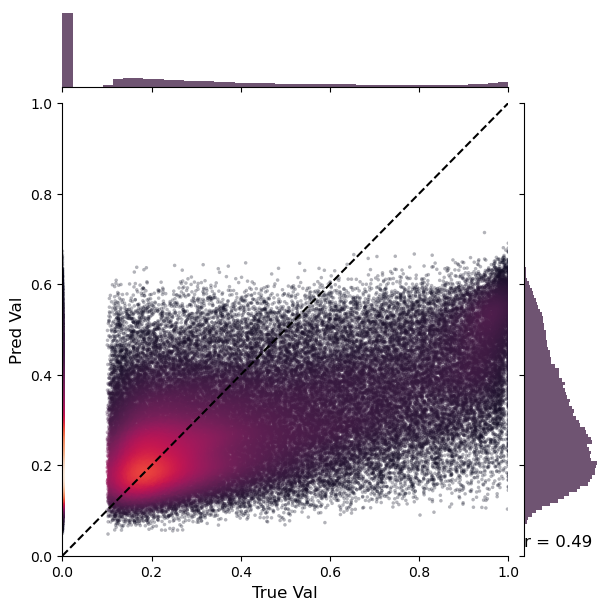

In [47]:
plot_correlation(train_validation_df["true_control"], train_validation_df["pred_control"], title="Train Control Data", interactive=True)
plot_correlation(train_validation_df["true_case"], train_validation_df["pred_case"], title="Train Case Data", interactive=True)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

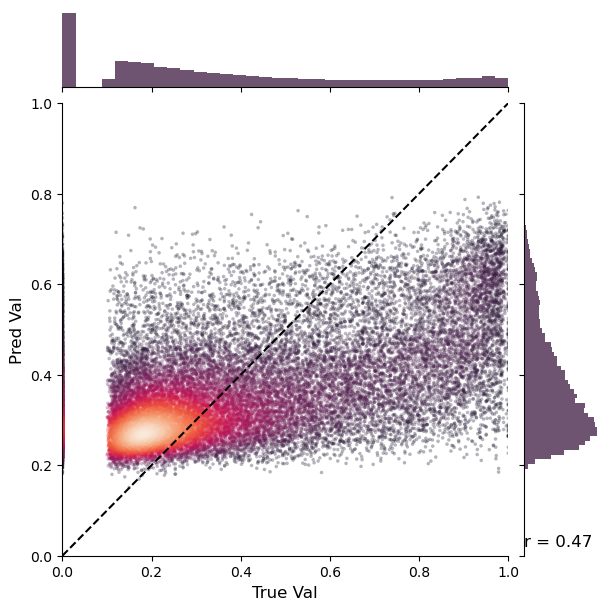

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

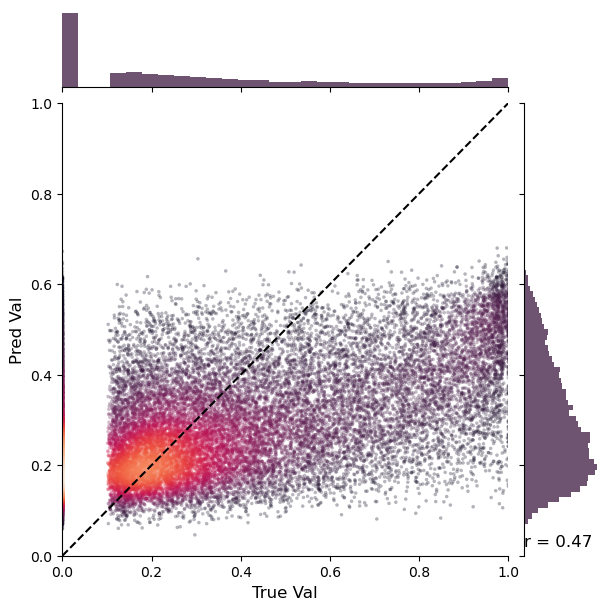

In [48]:
plot_correlation(test_validation_df["true_control"], test_validation_df["pred_control"], title="Test Control Data", interactive=True)
plot_correlation(test_validation_df["true_case"], test_validation_df["pred_case"], title="Test Case Data", interactive=True)

In [283]:
train_control_se = ((train_validation_df["true_control"] - train_validation_df["pred_control"])**2)
train_case_se = ((train_validation_df["true_case"] - train_validation_df["pred_case"])**2)
train_validation_df["train_control_se"] = train_control_se
train_validation_df["train_case_se"] = train_case_se


test_control_se = ((test_validation_df["true_control"] - test_validation_df["pred_control"])**2)
test_case_se = ((test_validation_df["true_case"] - test_validation_df["pred_case"])**2)
test_validation_df["test_control_se"] = test_control_se
test_validation_df["test_case_se"] = test_case_se

In [137]:
test_validation_df

,true_control,true_case,pred_control,pred_case,true_control_bin,true_case_bin,test_control_se,test_case_se
0,0.1250,0.0000,0.280962,0.246335,0.12,0.00,0.024324,6.068089e-02
1,0.6414,0.6398,0.613604,0.510280,0.64,0.63,0.000773,1.677552e-02
2,0.1932,0.0000,0.375667,0.259788,0.19,0.00,0.033294,6.749003e-02
3,0.3377,0.6667,0.429724,0.387682,0.33,0.66,0.008468,7.785114e-02
4,0.3794,0.6644,0.486184,0.499197,0.37,0.66,0.011403,2.729197e-02
...,...,...,...,...,...,...,...,...
27478,0.3173,0.0000,0.406077,0.378882,0.31,0.00,0.007881,1.435515e-01
27479,0.0000,0.1382,0.229388,0.093505,0.00,0.13,0.052619,1.997629e-03
27480,0.4722,0.0000,0.422588,0.408584,0.47,0.00,0.002461,1.669407e-01
27481,0.7765,0.6825,0.303554,0.196533,0.77,0.68,0.223678,2.361634e-01


Text(0.5, 0.01, 'Squared Error')

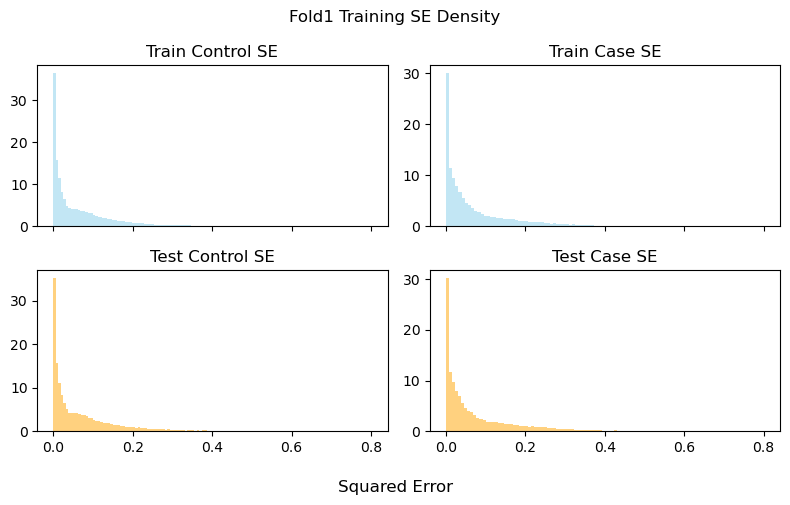

In [284]:
fig, axs = plt.subplots(2, 2, sharex=True, tight_layout=True, figsize=(8, 5))

# We can set the number of bins with the *bins* keyword argument.
axs[0][0].hist(train_validation_df["train_control_se"], bins=101, alpha=.5, color = "skyblue", density=True)
axs[0][0].set_title("Train Control SE")
axs[1][0].hist(test_validation_df["test_control_se"], bins=101, alpha=.5, color = "orange", density=True)
axs[1][0].set_title("Test Control SE")
axs[0][1].hist(train_validation_df["train_case_se"], bins=101, alpha=.5, color = "skyblue", density=True)
axs[0][1].set_title("Train Case SE")
axs[1][1].hist(test_validation_df["test_case_se"], bins=101, alpha=.5, color = "orange", density=True)
axs[1][1].set_title("Test Case SE")
fig.suptitle(f"Fold{fold} Training SE Density")
fig.supxlabel("Squared Error")

Text(0.5, 0.98, 'Error Correlation Between Bin Size and MSE (Hypoxia Data)\n(Fold = 1, R = -0.103)')

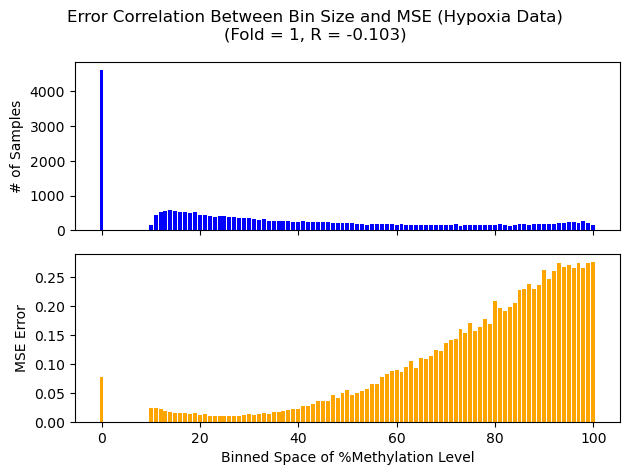

In [290]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)

num_sample = test_validation_df["true_control_bin"].cat.codes.value_counts().sort_index().reindex(range(101), fill_value=0)
axs[0].bar(np.arange(0,101), num_sample, color='blue')
axs[0].set_ylabel("# of Samples")
mse = test_validation_df[["test_case_se", "true_case_bin"]].groupby("true_case_bin", observed=True).mean().iloc[:,0]
mse.index = mse.index.codes
mse = mse.sort_index().reindex(range(101), fill_value=0)
axs[1].bar(np.arange(0,101), mse, color='orange')
axs[1].set_ylabel("MSE Error")
axs[1].set_xlabel("Binned Space of %Methylation Level")
fig.suptitle(f"Error Correlation Between Bin Size and MSE (Hypoxia Data)\n(Fold = {fold}, R = {np.corrcoef(num_sample, mse)[0,1]:.3f})")

Text(0.5, 0.98, 'Error Correlation Between Bin Size and MSE (Control Data)\n(Fold = 1, R = 0.044)')

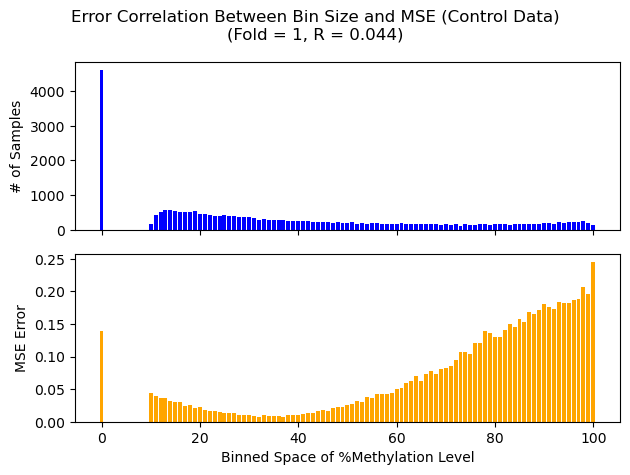

In [289]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)

num_sample = test_validation_df["true_control_bin"].cat.codes.value_counts().sort_index().reindex(range(101), fill_value=0)
axs[0].bar(np.arange(0,101), num_sample, color='blue')
axs[0].set_ylabel("# of Samples")
mse = test_validation_df[["test_control_se", "true_control_bin"]].groupby("true_control_bin", observed=True).mean().iloc[:,0]
mse.index = mse.index.codes
mse = mse.sort_index().reindex(range(101), fill_value=0)
axs[1].bar(np.arange(0,101), mse, color='orange')
axs[1].set_ylabel("MSE Error")
axs[1].set_xlabel("Binned Space of %Methylation Level")
fig.suptitle(f"Error Correlation Between Bin Size and MSE (Control Data)\n(Fold = {fold}, R = {np.corrcoef(num_sample, mse)[0,1]:.3f})")

TRY TO BINNING DATA TO GET THE CORRELATION BETWEEN NUMBER oF DATA ON EACH BIN AND THE ERROR 

In [1]:
import torch 
import numpy as np 
import pandas as pd
import sys
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
from wrapper.utils import plot_correlation
from model import TestMotifModel, TestMotifModelDropoutTest
from wrapper import utils
from torch.utils.data import DataLoader
from wrapper.data_setup import SequenceDatasetDual,SequenceDatasetDualFilter
import matplotlib.pyplot as plt
fold = 1
batch_size = 256
data_folder = "/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs"

seq_fasta_train_path = f"{data_folder}/motif_fasta_train_SPLIT_{fold}.fasta"
meta_data_train_json_path = f"{data_folder}/train_meta_data_SPLIT_{fold}.json"
train_dataset = SequenceDatasetDualFilter(seq_fasta_path=seq_fasta_train_path, meta_data_path=meta_data_train_json_path)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

seq_fasta_test_path = f"{data_folder}/motif_fasta_test_SPLIT_{fold}.fasta"
meta_data_test_json_path = f"{data_folder}/test_meta_data_SPLIT_{fold}.json"
test_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_test_path, meta_data_path=meta_data_test_json_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_temp_filter_training_data.pkl",
                        map_location=torch.device('cpu'))
config = {'cnn_first_filter': 16, 'cnn_first_kernel_size': 9, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 128, 'fc_size': 64}          
model = TestMotifModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                                            cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                                            output_size=2)
model.load_state_dict(model_weight)
model.eval()

device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TestMotifModel(
  (CNN): Sequential(
    (CNN_1): Conv1d(4, 16, kernel_size=(9,), stride=(1,), padding=same)
    (RELU_1): ReLU()
    (DROPOUT_1): Dropout(p=0.2, inplace=False)
    (BATCHNORM_1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (CNN_2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=same)
    (RELU_2): ReLU()
    (BATCHNORM_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (CNN_3): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=same)
    (RELU_3): ReLU()
    (BATCHNORM_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (biLSTM): LSTM(32, 128, num_layers=3, batch_first=Tru

In [5]:
train_df = infer(model, train_loader)
test_df = infer(model, test_loader)

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

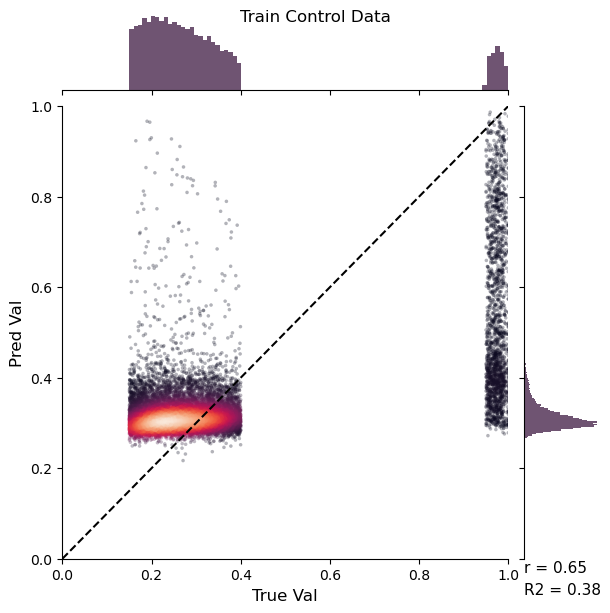

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

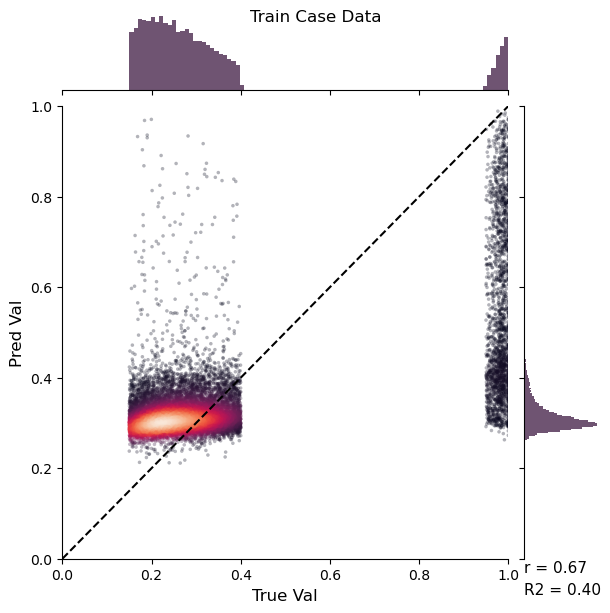

In [6]:
plot_correlation(train_df["true_control"], train_df["pred_control"], title="Train Control Data", interactive=True), plot_correlation(train_df["true_case"], train_df["pred_case"], title="Train Case Data", interactive=True);

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

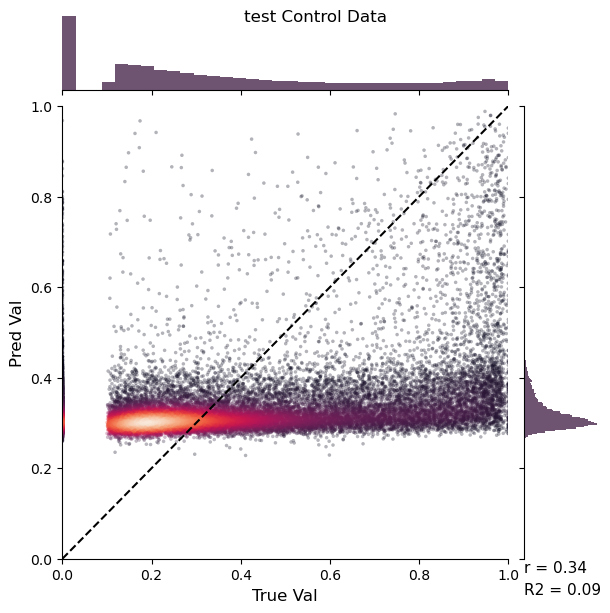

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

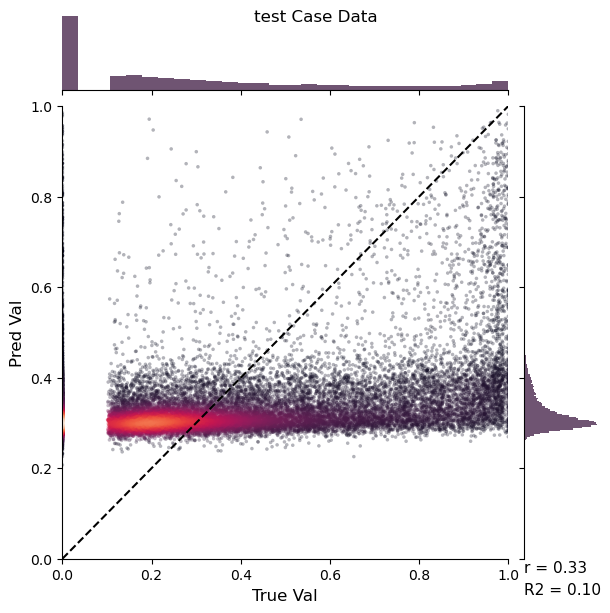

In [7]:
plot_correlation(test_df["true_control"], test_df["pred_control"], title="Test Control Data", interactive=True), plot_correlation(test_df["true_case"], test_df["pred_case"], title="Test Case Data", interactive=True);

In [15]:

for name, param in model.named_parameters():
    if name in ["CNN.CNN_1.weight", "CNN.CNN_1.bias"]
    print(f"Name: {name} Pram Shape: {param.shape}")

Name: CNN.CNN_1.weight Pram Shape: torch.Size([16, 4, 9])
Name: CNN.CNN_1.bias Pram Shape: torch.Size([16])
Name: CNN.BATCHNORM_1.weight Pram Shape: torch.Size([16])
Name: CNN.BATCHNORM_1.bias Pram Shape: torch.Size([16])
Name: CNN.CNN_2.weight Pram Shape: torch.Size([32, 16, 7])
Name: CNN.CNN_2.bias Pram Shape: torch.Size([32])
Name: CNN.BATCHNORM_2.weight Pram Shape: torch.Size([32])
Name: CNN.BATCHNORM_2.bias Pram Shape: torch.Size([32])
Name: CNN.CNN_3.weight Pram Shape: torch.Size([32, 32, 7])
Name: CNN.CNN_3.bias Pram Shape: torch.Size([32])
Name: CNN.BATCHNORM_3.weight Pram Shape: torch.Size([32])
Name: CNN.BATCHNORM_3.bias Pram Shape: torch.Size([32])
Name: biLSTM.weight_ih_l0 Pram Shape: torch.Size([512, 32])
Name: biLSTM.weight_hh_l0 Pram Shape: torch.Size([512, 128])
Name: biLSTM.bias_ih_l0 Pram Shape: torch.Size([512])
Name: biLSTM.bias_hh_l0 Pram Shape: torch.Size([512])
Name: biLSTM.weight_ih_l0_reverse Pram Shape: torch.Size([512, 32])
Name: biLSTM.weight_hh_l0_reverse P

In [53]:
import torch 
import re 
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


first_conv1d = None
first_conv1d_name = ""
last_conv1d = None
last_conv1d_name = ""
lstm = None
lstm_param  = {}

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv1d):
        if first_conv1d is None:
            first_conv1d = module
            first_conv1d_name = name
        last_conv1d = module
        last_conv1d_name = name
    if isinstance(module, torch.nn.LSTM):
        lstm = module 
        if lstm:
            lstm_layer = lstm.num_layers
            is_bidirection = lstm.bidirectional
            for param in lstm.named_parameters():
                layer = int((re.search(r"l\d+", param[0])).group()[-1])
                h_stat = re.search(r"[i,h]h", param[0]).group()[0]
                if layer == 0:
                    print(f"Param name: {param[0]} with shape of: {param[1].shape}")
                    if str(param[0]) == "weight_ih_l0":
                        lstm_param["kernel_weight"] = param[1].detach()
                    if str(param[0]) == "weight_hh_l0":
                        lstm_param["recurrent_weight"] = param[1].detach()
                    if str(param[0]) == "bias_ih_l0":
                        lstm_param["kernel_bias"] = param[1].detach()
                    if str(param[0]) == "bias_hh_l0":
                        lstm_param["recurrent_bias"] = param[1].detach()

In [279]:
import torch

# Suppose we have a simple temp_model with one linear layer
temp_model = torch.nn.Linear(in_features=5, out_features=1)
criterion = torch.nn.MSELoss()  # Mean Squared Error temp_loss

# Example input and target output
temp_inputs = torch.tensor([[1.0, 2.0, 4, 3, 2]], requires_grad=True)
temp_targets = torch.tensor([[1.0]])

# Forward pass: compute predicted output
outputs = temp_model(temp_inputs)

# Compute temp_loss
temp_loss = criterion(outputs, temp_targets)

# Backward pass: compute gradient of the temp_loss with respect to temp_model parameters
temp_loss.backward()

# Print gradients
print("Gradients on the weights:", temp_model.weight.grad)
print("Gradients on the bias:", temp_model.bias.grad)

Gradients on the weights: tensor([[-0.4180, -0.8360, -1.6720, -1.2540, -0.8360]])
Gradients on the bias: tensor([-0.4180])


In [294]:
print(lstm.hidden_size)
if lstm:
    lstm_layer = lstm.num_layers
    is_bidirection = lstm.bidirectional
    for param in lstm.named_parameters():
        layer = int((re.search(r"l\d+", param[0])).group()[-1])
        h_stat = re.search(r"[i,h]h", param[0]).group()[0]
        if layer == 0:
            print(f"Param name: {param[0]} with shape of: {param[1].shape}")
            if str(param[0]) == "weight_ih_l0":
                lstm_param["kernel_weight"] = param[1].detach()
            if str(param[0]) == "weight_hh_l0":
                lstm_param["recurrent_weight"] = param[1].detach()
            if str(param[0]) == "bias_ih_l0":
                lstm_param["kernel_bias"] = param[1].detach()
            if str(param[0]) == "bias_hh_l0":
                lstm_param["recurrent_bias"] = param[1].detach()
            if str(param[0]) == "weight_ih_l0_reverse":
                lstm_param["kernel_weight_reverse"] = param[1].detach()
            if str(param[0]) == "weight_hh_l0_reverse":
                lstm_param["recurrent_weight_reverse"] = param[1].detach()
            if str(param[0]) == "bias_ih_l0_reverse":
                lstm_param["kernel_bias_reverse"] = param[1].detach()
            if str(param[0]) == "bias_hh_l0_reverse":
                lstm_param["recurrent_bias_reverse"] = param[1].detach()

128
Param name: weight_ih_l0 with shape of: torch.Size([512, 32])
Param name: weight_hh_l0 with shape of: torch.Size([512, 128])
Param name: bias_ih_l0 with shape of: torch.Size([512])
Param name: bias_hh_l0 with shape of: torch.Size([512])
Param name: weight_ih_l0_reverse with shape of: torch.Size([512, 32])
Param name: weight_hh_l0_reverse with shape of: torch.Size([512, 128])
Param name: bias_ih_l0_reverse with shape of: torch.Size([512])
Param name: bias_hh_l0_reverse with shape of: torch.Size([512])


In [297]:
def lstm_plot(lstm_param, is_reverse:False):
    is_reverse = "_reverse" if is_reverse else ""
    print(f"kernel_weight{is_reverse}")
    weight_data = lstm_param[f"kernel_weight{is_reverse}"].T
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8, 1]}, figsize=(10, 5))
    fig.tight_layout()
    # sns.set(font_scale=1)
    # weights
    ax = sns.heatmap(ax=axs[0], data=weight_data, cmap="PiYG")
    for i in range(0, weight_data.shape[1], lstm.hidden_size):
        if i!=0:
            ax.vlines(i, ymin=0, ymax=weight_data.shape[0], colors='black', linewidth=1)
    ax.set_xticks(range(0, weight_data.shape[1],25), range(0, weight_data.shape[1],25))
    ax.set_title("Kernel Weight", weight='bold', size=8)
    ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
    ax.set_ylabel("Input Units")
    # bias
    bias_data = lstm_param[f"kernel_bias{is_reverse}"].unsqueeze(0)
    ax = sns.heatmap(ax=axs[1], data=bias_data, cmap="PiYG", cbar=False, yticklabels=False, xticklabels=8)
    for i in range(0, bias_data.shape[1], lstm.hidden_size):
        if i!=0:
            ax.vlines(i, ymin=0, ymax=bias_data.shape[0], colors='black', linewidth=1)
    ax.set_title("Kernel Bias", weight='bold', size=8)
    ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
    ax.set_xticks(range(0, bias_data.shape[1],25), range(0, bias_data.shape[1],25))
    plt.subplots_adjust(hspace=0.5)
    plt.show()

kernel_weight_reverse


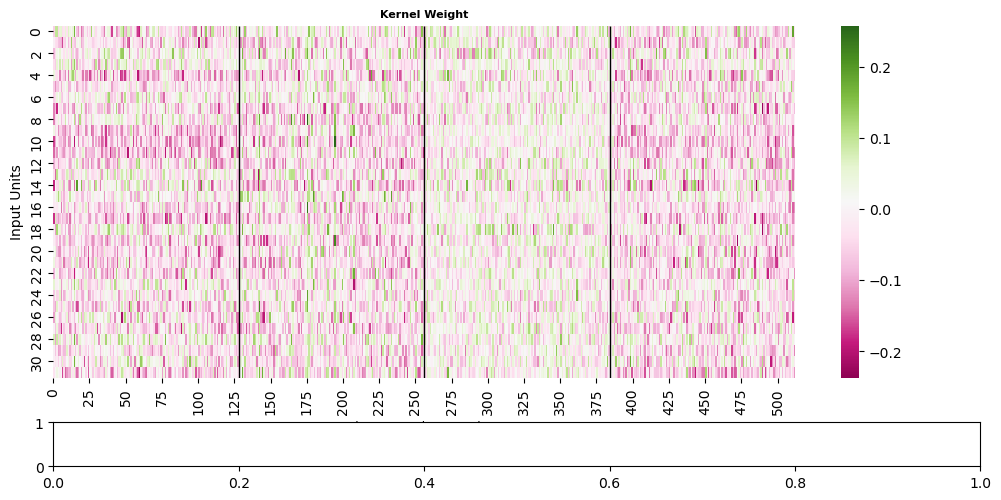

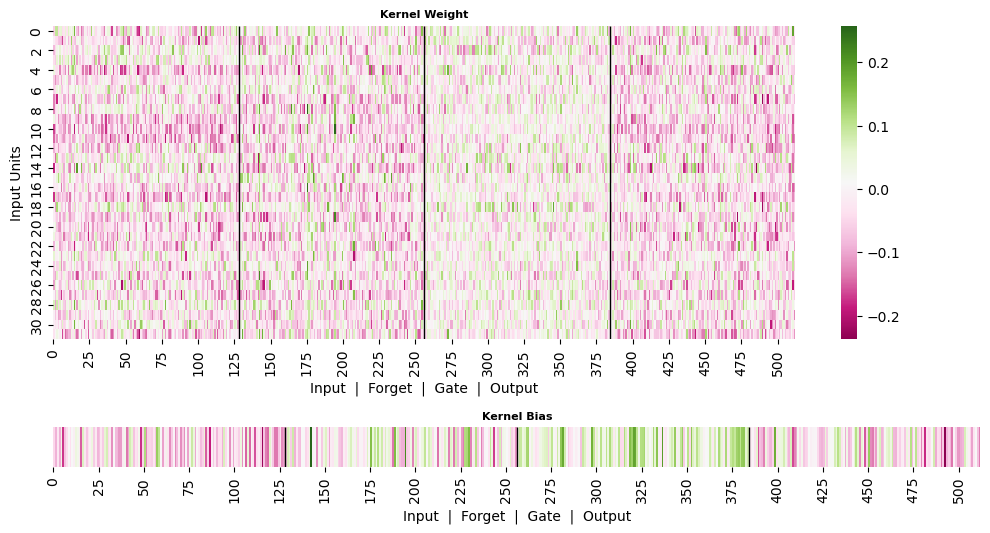

In [298]:
lstm_plot(lstm_param, True)

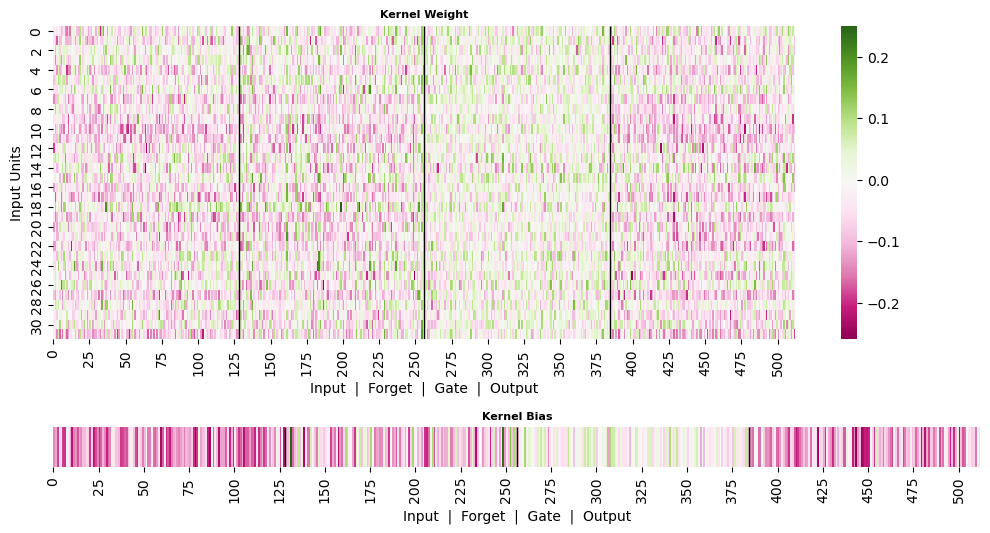

In [266]:
import matplotlib.ticker as ticker
weight_data = lstm_param["kernel_weight"].T
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8, 1]}, figsize=(10, 5))
fig.tight_layout()
# sns.set(font_scale=1)
# weights
ax = sns.heatmap(ax=axs[0], data=weight_data, cmap="PiYG")
for i in range(0, weight_data.shape[1], lstm.hidden_size):
    if i!=0:
        ax.vlines(i, ymin=0, ymax=weight_data.shape[0], colors='black', linewidth=1)
ax.set_xticks(range(0, weight_data.shape[1],25), range(0, weight_data.shape[1],25))
ax.set_title("Kernel Weight", weight='bold', size=8)
ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
ax.set_ylabel("Input Units")
# bias
bias_data = lstm_param["kernel_bias"].unsqueeze(0)
ax = sns.heatmap(ax=axs[1], data=bias_data, cmap="PiYG", cbar=False, yticklabels=False, xticklabels=8)
for i in range(0, bias_data.shape[1], lstm.hidden_size):
    if i!=0:
        ax.vlines(i, ymin=0, ymax=bias_data.shape[0], colors='black', linewidth=1)
ax.set_title("Kernel Bias", weight='bold', size=8)
ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
ax.set_xticks(range(0, bias_data.shape[1],25), range(0, bias_data.shape[1],25))
plt.subplots_adjust(hspace=0.5)
plt.show()

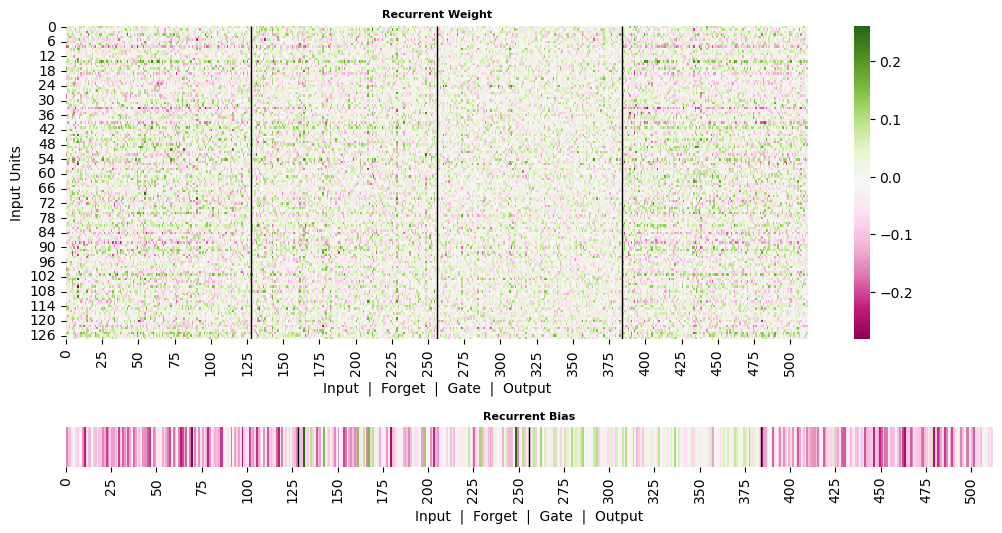

In [267]:
weight_data = lstm_param["recurrent_weight"].T
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8, 1]}, figsize=(10, 5))
fig.tight_layout()
# sns.set(font_scale=1)
# weights
ax = sns.heatmap(ax=axs[0], data=weight_data, cmap="PiYG")
for i in range(0, weight_data.shape[1], lstm.hidden_size):
    if i!=0:
        ax.vlines(i, ymin=0, ymax=weight_data.shape[0], colors='black', linewidth=1)
ax.set_xticks(range(0, weight_data.shape[1],25), range(0, weight_data.shape[1],25))
ax.set_title("Recurrent Weight", weight='bold', size=8)
ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
ax.set_ylabel("Input Units")
# bias
bias_data = lstm_param["recurrent_bias"].unsqueeze(0)
ax = sns.heatmap(ax=axs[1], data=bias_data, cmap="PiYG", cbar=False, yticklabels=False, xticklabels=8)
for i in range(0, bias_data.shape[1], lstm.hidden_size):
    if i!=0:
        ax.vlines(i, ymin=0, ymax=bias_data.shape[0], colors='black', linewidth=1)
ax.set_title("Recurrent Bias", weight='bold', size=8)
ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
ax.set_xticks(range(0, bias_data.shape[1],25), range(0, bias_data.shape[1],25))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [34]:
import re
import numpy as np 
import torch
from matplotlib import pyplot as plt 
import pandas as pd
import seaborn as sns
def lstm_plot(lstm_param, hidden_size, is_reverse=False, interactive=False):
    is_reverse = "_reverse" if is_reverse else ""
    weight_data = lstm_param[f"kernel_weight{is_reverse}"].T
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8, 1]}, figsize=(10, 5))
    fig.tight_layout()
    # sns.set(font_scale=1)
    # weights
    ax = sns.heatmap(ax=axs[0], data=weight_data, cmap="PiYG")
    for i in range(0, weight_data.shape[1], hidden_size):
        if i!=0:
            ax.vlines(i, ymin=0, ymax=weight_data.shape[0], colors='black', linewidth=1)
    ax.set_xticks(range(0, weight_data.shape[1],25), range(0, weight_data.shape[1],25))
    ax.set_title(f"Kernel Weight{is_reverse}", weight='bold', size=8)
    ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
    ax.set_ylabel("Input Units")
    # bias
    bias_data = lstm_param[f"kernel_bias{is_reverse}"].unsqueeze(0)
    ax = sns.heatmap(ax=axs[1], data=bias_data, cmap="PiYG", cbar=False, yticklabels=False, xticklabels=8)
    for i in range(0, bias_data.shape[1], hidden_size):
        if i!=0:
            ax.vlines(i, ymin=0, ymax=bias_data.shape[0], colors='black', linewidth=1)
    ax.set_title(f"Kernel Bias{is_reverse}", weight='bold', size=8)
    ax.set_xlabel("Input  |  Forget  |  Gate  |  Output")
    ax.set_xticks(range(0, bias_data.shape[1],25), range(0, bias_data.shape[1],25))
    plt.subplots_adjust(hspace=0.5)
    return plt

def extract_lstm_info(model):
    lstm = None
    lstm_param  = {}
    is_bidirection = False
    plts = {}
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.LSTM):
            lstm = module 
            lstm_layer = lstm.num_layers
            is_bidirection = lstm.bidirectional
            for param in lstm.named_parameters():
                layer = int((re.search(r"l\d+", param[0])).group()[-1])
                h_stat = re.search(r"[i,h]h", param[0]).group()[0]
                if layer == 0:
                    # print(f"Param name: {param[0]} with shape of: {param[1].shape}")
                    if str(param[0]) == "weight_ih_l0":
                        lstm_param["kernel_weight"] = param[1].detach().cpu()
                    if str(param[0]) == "weight_hh_l0":
                        lstm_param["recurrent_weight"] = param[1].detach().cpu()
                    if str(param[0]) == "bias_ih_l0":
                        lstm_param["kernel_bias"] = param[1].detach().cpu()
                    if str(param[0]) == "bias_hh_l0":
                        lstm_param["recurrent_bias"] = param[1].detach().cpu()
                    if str(param[0]) == "weight_ih_l0_reverse":
                        lstm_param["kernel_weight_reverse"] = param[1].detach().cpu()
                    if str(param[0]) == "weight_hh_l0_reverse":
                        lstm_param["recurrent_weight_reverse"] = param[1].detach().cpu()
                    if str(param[0]) == "bias_ih_l0_reverse":
                        lstm_param["kernel_bias_reverse"] = param[1].detach().cpu()
                    if str(param[0]) == "bias_hh_l0_reverse":
                        lstm_param["recurrent_bias_reverse"] = param[1].detach().cpu()
    
    plts["forward_direction"] = lstm_plot(lstm_param,  lstm.hidden_size)
    if is_bidirection:
        plts["backward_direction"] = lstm_plot(lstm_param, lstm.hidden_size, is_reverse=True)
    return plts
                      

<class 'module'>
<class 'module'>


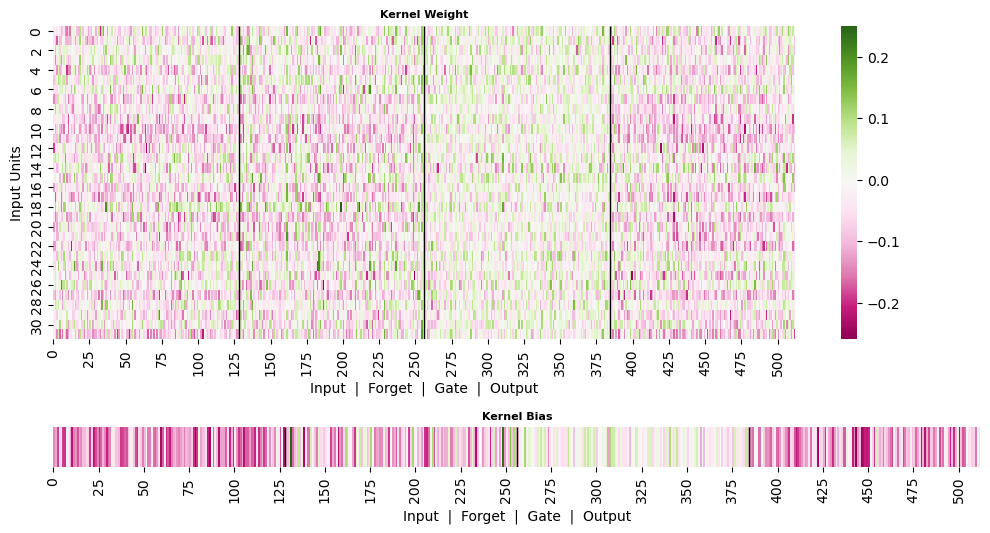

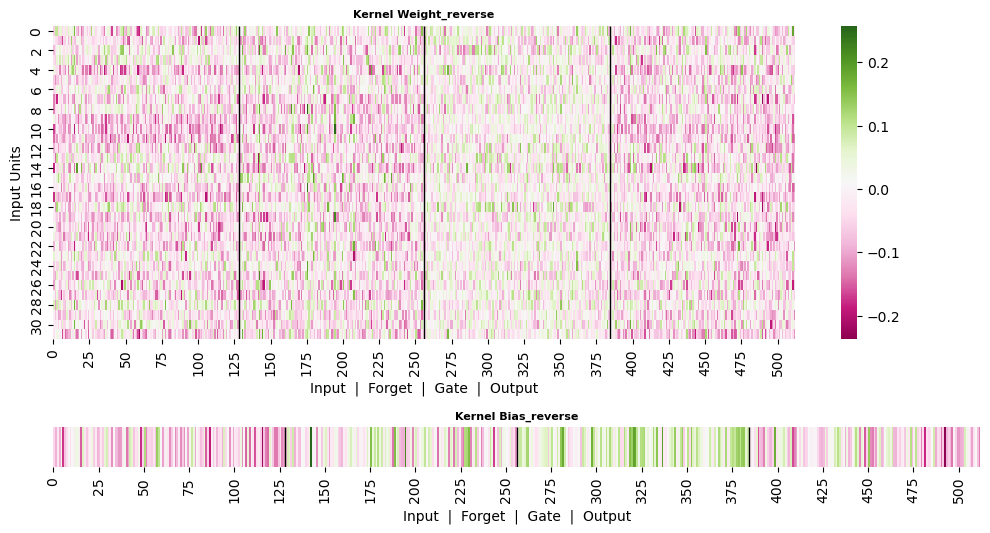

In [23]:
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
from wrapper.utils import create_tensorboard_log_writer, extract_lstm_info

tensorboard_writer = create_tensorboard_log_writer(experiment_name=f"test", model_name=model.__class__.__name__, log_dir=f"data/outputs/tensorboard_logs")

[INFO] Created SummaryWriter, saving to: data/outputs/tensorboard_logs/runs/2024-04-16/test/TestMotifModel...


In [3]:
config = {'cnn_first_filter': 16, 'cnn_first_kernel_size': 9, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 128, 'fc_size': 64}
model = TestMotifModel(input_channel=4, input_size=1001, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                        cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                        output_size=2)

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
def initialize_kaiming_weights(model: torch.nn.Module):
    """
    Initialize all the weight of the conv1d and linear as in https://paperswithcode.com/method/he-initialization

    param: model: torch.nn.Module: model
    """
    for name, module in model.named_modules():
        # print(module)
        if isinstance(module, (torch.nn.Conv1d, torch.nn.Linear)):
            print(module)
            torch.nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                print("Module has bias")
                torch.nn.init.zeros_(module.bias)

In [16]:
model(torch.randn(64, 4, 1001))
initialize_kaiming_weights(model)

Conv1d(4, 16, kernel_size=(9,), stride=(1,), padding=same)
Module has bias
Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=same)
Module has bias
Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=same)
Module has bias
Linear(in_features=15872, out_features=64, bias=True)
Module has bias
Linear(in_features=64, out_features=64, bias=True)
Module has bias
Linear(in_features=64, out_features=2, bias=True)
Module has bias
